<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Raleway:wght@100&display=swap" rel="stylesheet">

<h1 style="text-transform: uppercase; text-align: center; font-weight: 100;">
Linear regression in Tensorflow using RNN</h1>
<p style="text-align: center; font-weight: 100;">Predicting Volkswagen car prices</p><br/>

Project requirements:
- Only requirement is: minimum 10k rows
- Any type of neural network - classical but convolutional and recurrent, better grade
- Presentation of project, beside practical questions about model there would be also theoretical.
The topic is free.

Theory required for project presentation:
- Practical side.
- Discuss the scheme of an artificial neuron.
- Activation function, why it is so important.
- Explain how does neuron learn - steps, algorithm?
- How does basic neural network work? (The more you know the better, as well as more complex).
- Discuss the algorithm of neural network using backpropagation learning method. (metoda wstecznej propagacji błędów)
- What subsets and why are the data divided into?
Knowledge of ML, statistics.

Data source: data were taken from the popular Polish automotive website Otomoto (https://www.otomoto.pl/).

1. Import libraries and create dataframe:

In [13]:
import sklearn as sl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import tensorflow as tf
import keras.utils
from sklearn.model_selection import train_test_split
# from model import VolkswagenModel
# from colorama import init, Fore, Style

print(f"np: {np.__version__}, pd: {pd.__version__}, tf: {tf.__version__}, mpl: {mpl.__version__}, sb: {sns.__version__}, sm: {sm.__version__}, sl: {sl.__version__}")
print("Libs loaded.")

data = pd.read_csv("./data/otomoto.csv")
df = pd.DataFrame(data)
df = df.drop(df.columns[0], axis=1)
df.columns = ['Price', 'Year', 'Mileage', 'Tank capacity', 'Fuel type', 'Model', 'Estimation']
print("Data technical info")
df.info()
df

np: 1.23.2, pd: 1.4.4, tf: 2.11.0, mpl: 3.5.3, sb: 0.12.1, sm: 0.13.2, sl: 1.0.2
Libs loaded.
Data technical info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14915 entries, 0 to 14914
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Price          14915 non-null  int64
 1   Year           14915 non-null  int64
 2   Mileage        14915 non-null  int64
 3   Tank capacity  14915 non-null  int64
 4   Fuel type      14915 non-null  int64
 5   Model          14915 non-null  int64
 6   Estimation     14915 non-null  int64
dtypes: int64(7)
memory usage: 815.8 KB


,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
0,24900,2010,166000,1390,1,16,0
1,16500,2007,194000,1968,7,39,0
2,364510,2022,5400,1968,7,8,0
3,9999,2005,196425,1390,1,35,2
4,39900,2010,227000,1968,7,32,0
...,...,...,...,...,...,...,...
14910,119500,2020,52000,1498,1,41,2
14911,31000,2002,511000,2461,7,9,0
14912,23500,2011,223000,1390,1,16,1
14913,29800,2012,190000,1598,7,16,2


In [14]:
description = df.describe()
description

,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
count,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000
mean,61420.578478,2012.424137,172886.681931,1755.932618,4.436876,27.893530,1.410325
std,61593.454821,6.757177,100170.759677,395.745487,2.952525,13.300906,1.071621
min,1500.000000,1958.000000,1.000000,77.000000,1.000000,1.000000,0.000000
25%,20000.000000,2008.000000,104343.000000,1498.000000,1.000000,16.000000,0.000000
50%,41999.000000,2013.000000,177000.000000,1896.000000,7.000000,32.000000,2.000000
75%,82900.000000,2018.000000,234350.000000,1968.000000,7.000000,39.000000,2.000000
max,570000.000000,2023.000000,700000.000000,5998.000000,7.000000,50.000000,3.000000


In [6]:
check = 14915
flag = True
for i in range(description.shape[1]):
    if description.iloc[0, i] != check:
        print("Number of occurrences of data is not equal for every label.")
        print(f"Problem at cell: (0, {i})")
        flag = False
        continue
    else:
        print(f"Checked: (0, {i})")

print("All columns passed" if flag == True else "Not passed")

Checked: (0, 0)
Checked: (0, 1)
Checked: (0, 2)
Checked: (0, 3)
Checked: (0, 4)
Checked: (0, 5)
Checked: (0, 6)
All columns passed


2. Clean data:

    Data was cleaned previously in 'scratchpad.py' file and now all the records are represented by integers(documentation of each column values is located in 'model.py' file). Values ​​of 0 represent an error in reading data. Column "Estimation" contains a lot of 0 values, but this is due to the fact that not every article on the website contained such information.

In [ ]:
counter = 0
for index, row in df.iterrows():
    if row["Price"] == 0 or row["Year"] == 0 or row["Mileage"] == 0 or row["Tank capacity"] == 0 or row["Model"] == 0: 
        counter += 1
print(counter)


Getting know data, analyzing dependencies


Histograms

In [ ]:
def make_hist(col_name, bins_val):
    min = df[col_name].min()
    max = df[col_name].max()
    print(f"Lowest {col_name} value: {min}. Highest {col_name} value: {max}.")
    plot_hist = df[col_name].plot.hist(bins=bins_val, grid=True)
    plot_hist.set_title(f"Represents number of cars for each production {col_name.upper()} category")
    plot_hist.set_xlabel(f"{col_name}")
    plot_hist.set_ylabel("Number of observations")
    plt.show()

In [ ]:
make_hist("Price", 57)

In [ ]:
min = df["Year"].min()
max = df["Year"].max()
make_hist("Year", max-min)

In [ ]:
make_hist("Mileage", 70)

In [ ]:
make_hist("Tank capacity", 10) # default bins = 10

# Trzeba jeszcze dopasować przedziały

In [ ]:
make_hist("Fuel type", 10) # default bins = 10

In [ ]:
NO_cars_fuel = df['Fuel type'].value_counts().reset_index()
NO_cars_fuel = NO_cars_fuel.rename(columns={'index': 'type of fuel', 'Fuel type': 'NO of cars with specific fuel type'})
# NaN
# d = {"Benzyna": 1, "Benzyna+LPG": 2, "Benzyna+CNG": 3, "Elektryczny": 4, "Hybryda": 5, "Wodór": 6, "Diesel": 7}
# unique_values['name of fuel'] = unique_values['type of fuel'].map(d)
NO_cars_fuel

In [ ]:
make_hist("Model", 29)

In [ ]:
make_hist("Estimation", 10) # default bins = 10

Distribution of cars per column per certain category from column in numbers.

In [ ]:
# pr = df['Price'].value_counts().reset_index()
# yr = df['Year'].value_counts().reset_index()
# mil = df['Mileage'].value_counts().reset_index()
# tank = df['Tank capacity'].value_counts().reset_index()
# fuel = df['Fuel type'].value_counts().reset_index()
mod = df['Model'].value_counts().reset_index()
est = df['Estimation'].value_counts().reset_index()

# pr = pr.rename(columns={'index': 'price_cat', 'Price': 'NO_cars'})
# yr = yr.rename(columns={'index': 'year_cat', 'Year': 'NO_cars'})
# mil = mil.rename(columns={'index': 'mileage_cat', 'Mileage': 'NO_cars'})
# tank = tank.rename(columns={'index': 'tank_capacity', 'Tank capacity': 'NO_cars'})
# fuel = fuel.rename(columns={'index': 'type_fuel', 'Fuel type': 'NO_cars'})
mod = mod.rename(columns={'index': 'type_model', 'Model': 'NO_cars'})
est = est.rename(columns={'index': 'type_est', 'Estimation': 'NO_cars'})

def create_table(table_data, table_title):
    fig = plt.figure()
    table = plt.table(cellText=table_data.values, colLabels=table_data.columns, loc='upper left')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 1.5)
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.title(table_title)
    plt.axis('off')
    return fig

# table1 = create_table(pr, "Pr")
# table2 = create_table(yr, "Yr")
# table3 = create_table(mil, "Mil")
# table4 = create_table(tank, "Tank")
# table5 = create_table(fuel, "Fuel")
table6 = create_table(mod, "Mod")
table7 = create_table(est, "Est")

Box plots

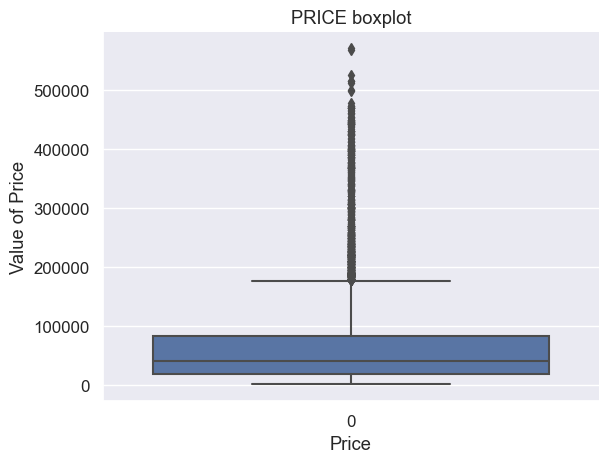

In [21]:
sns.boxplot(df['Price']).set(title="PRICE boxplot", xlabel="Price", ylabel="Value of Price")
sns.despine()

In [ ]:
# # create FacetGrid
# grid = sns.FacetGrid(pd.melt(df.reset_index(), id_vars=['index']), col='variable', col_wrap=2)
#
# # plot boxplots on each facet
# grid.map(sns.boxplot, 'variable', 'value')
#
# # set titles and labels
# for ax in grid.axes.flat:
#     ax.set_title(ax.get_title().split('=')[1])
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#
# plt.subplots_adjust(top=0.9)
# grid.fig.suptitle('Boxplots Grid')
#
# plt.show()

def grid_boxplots(*args):
    col_list = [col for col in args]




Heat Map

    Price  Year  Mileage  Tank capacity  Fuel type  Model  Estimation
0   24900  2010   166000           1390          1     16           0
1   16500  2007   194000           1968          7     39           0
2  364510  2022     5400           1968          7      8           0
3    9999  2005   196425           1390          1     35           2
4   39900  2010   227000           1968          7     32           0


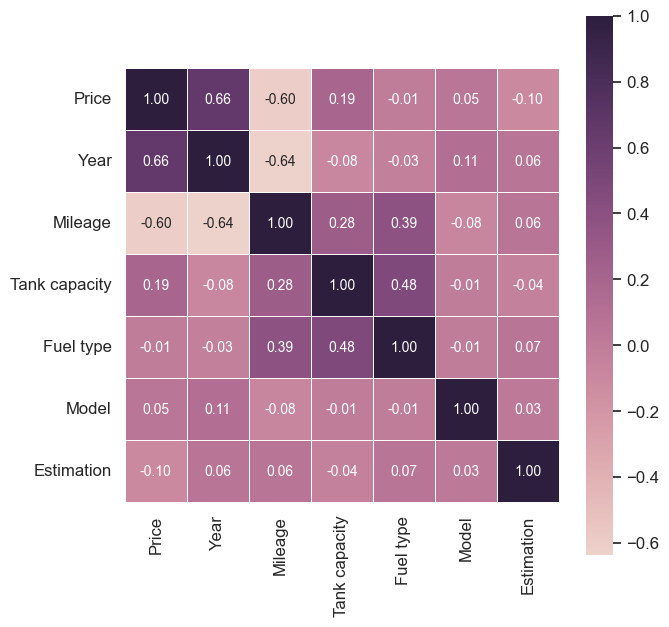

In [18]:
correlation_matrix = np.corrcoef(df.values.T)

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.1)
sns.heatmap(data=correlation_matrix, square=True, cbar=True, annot=True, annot_kws={'size': 10}, xticklabels=df.columns, yticklabels=df.columns, fmt=".2f", linewidth=.5, cmap=sns.cubehelix_palette(as_cmap=True))

print(df.head())

Building model

Outlier detection

In [ ]:
# https://www.kaggle.com/code/durgeshrao9993/removing-outliers-by-iqr-method



Heat Map - after outlier detection

Normalization / Scaling

In [19]:
# Normalization - we change the distribution of data, not the range of data like it is done in scaling. The point is to change your observations so that they can be described as a normal distribution.
# Normalization should be done after splitting into train and test data sets!!!
# https://keras.io/api/layers/preprocessing_layers/numerical/normalization/

# X = df.drop(['Price'], axis=1)
# y = df['Price']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# convert dataframe to numpy array
values = df.values
normalized_values = keras.utils.normalize(values, axis=0)
df_normalized = pd.DataFrame(normalized_values, columns=df.columns)
print("Normalization done")

Normalization done


Heat Map - after normalization

      Price      Year   Mileage  Tank capacity  Fuel type     Model  \
0  0.002344  0.008178  0.006803       0.006323   0.001536  0.004240   
1  0.001553  0.008166  0.007950       0.008953   0.010755  0.010334   
2  0.034314  0.008227  0.000221       0.008953   0.010755  0.002120   
3  0.000941  0.008158  0.008050       0.006323   0.001536  0.009274   
4  0.003756  0.008178  0.009303       0.008953   0.010755  0.008479   

   Estimation  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.009246  
4    0.000000  


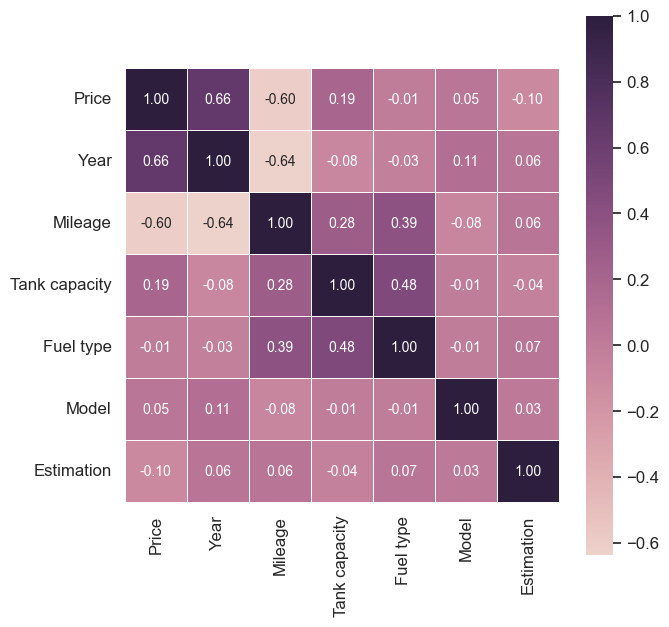

In [20]:
correlation_matrix = np.corrcoef(df_normalized.values.T)

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.1)
sns.heatmap(data=correlation_matrix, square=True, cbar=True, annot=True, annot_kws={'size': 10}, xticklabels=df.columns, yticklabels=df.columns, fmt=".2f", linewidth=.5, cmap=sns.cubehelix_palette(as_cmap=True))

print(df_normalized.head())

Pair plot

In [ ]:
sns.pairplot(df, height=1.5)

Splitting data into sets

In [ ]:
X = df.drop(['Price'], axis=1)
y = df['Price']

In [ ]:
data_size = len(df)
test_size = int(data_size * 0.2)  # 20% danych przeznaczamy na zbiór testowy
train_size = data_size - test_size


data = tf.data.Dataset.from_tensor_slices((X.values, y.values))
data = data.shuffle(buffer_size=data_size, reshuffle_each_iteration=True) # randomize data after each iteration (epoch)


# Helps to optimize code by dividing datasets into batches, portion of data instead of individual processing.
train_data = data.take(train_size).batch(32)
test_data = data.skip(train_size).take(test_size).batch(32)
X_train, y_train = next(iter(train_data))
X_test, y_test = next(iter(test_data))


# Print length of datasets portions
print(f"X_train len = {len(X_train)}")
print(f"y_train len = {len(y_train)}")
print(f"X_test len = {len(X_test)}")
print(f"y_test len = {len(y_test)}")


# Print datasets portions
# print('X_train = ', X_train)
# print('y_train = ', y_train)
# print('X_test = ', X_test)
# print('y_test = ', y_test)

In [ ]:
# Could be also use with similar effect as above cell as ScikitLearn way - without batches
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Model Architecture

In [ ]:
# https://www.tensorflow.org/guide/keras/rnn?hl=pl
# https://www.ibm.com/topics/recurrent-neural-networks

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(None, X_train.shape[-1])), # type of recurrent neural network
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Equivalent to:
# input_layer = tf.keras.layers.Input(shape=(None, X_train.shape[-1]))
# lstm_layer = tf.keras.layers.LSTM(64)(input_layer)
# dense_layer_1 = tf.keras.layers.Dense(32, activation='relu')(lstm_layer)
# output_layer = tf.keras.layers.Dense(1)(dense_layer_1)
# model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Training the model

In [ ]:
model.compile(

)

model.fit(


)

Evaluating the model

In [ ]:
print("Evaluate on test data")
loss, accuracy = model.evaluate()
print(f"test loss = {loss}, test acc = {accuracy}")

# WYKRED WARTOŚCI RESZTOWYCH - R2 method

### Possible DEPLOY - docker, github